# Test with random data

- Vamos entrenando el modelo semana a semana (aunque teóricamente podríamos hacerlo día a día)
- Cada semana hay que inicializar los compartimentos, únicamente conocemos el valor de Infectados y Muertes.
- El resto de compartimentos los podemos inferir de los compartimentos finales de las simulaciones de la semana anterior
    - Una opción es elegir la mejor simulación de la semana anterior, y ajustar una normal en cada compartimento y de ahi samplear
    - Otra opción es elegir las 1000 mejores simulaciones de la semana anterior, crear una distribución normal multivariada, y samplear los compartimentos de ahí, fijando eso si los infectados y muertes al valor real 
- El rango para fittear las 1000 mejores simulaciones no tiene por que ser solo la semana anterior, sino todo un mes (obligar al modelo a predecir a mayor escala)
- La métrica para seleccionar las 1000 mejores simulaciones puede ser el RMSE o un frente de Pareto
- Los hiperparámetros del modelo (beta, t_i, etc) también podríamos ir sampleandolos (como hacían los griegos, mejor eso que fijarlos para todo un año, la gente va cambiando su comportamiento, diferentes medidas, etc)
    - Los hiperparámetros y los compartimentos pueden ir en la misma distribución normal multivariada, o en distribuciones separadas
- La primera ronda de semillas hay que inicializarla de alguna manera: podemos usar las semillas que encontré manualmente, o podemos usar un GA, o un ABC para ellas...




In [1]:
using Plots
using MMCAcovid19
using Random
using Distributions
using LightGraphs
using NamedArrays
using LinearAlgebra


# Number of strata
G = 3

# Number of patches
M = 5

g_probs = [0.1, 0.6, 0.3]
m_probs = [0.05, 0.10, 0.15, 0.30, 0.40]
probs = transpose(m_probs) .* g_probs
total_population = 1000000
distrib = Multinomial(total_population, reshape(probs, (1, G * M))[1, :])
nᵢᵍ = convert.(Float64, reshape(rand(distrib), (G, M)))

# Strata contacts
C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

# network
network = erdos_renyi(M, 0.7, is_directed=true)
for i in 1:M
  add_edge!(network, i, i)   # add self-loops
end
# list of edges
L = ne(network)
edgelist = zeros(Int64, L, 2)
edgelist[:, 1] .= src.(edges(network))
edgelist[:, 2] .= dst.(edges(network))
# list of commuting probabilities
Rᵢⱼ = rand(L)
sum_r = zeros(M)
for e in 1:L   # find output strengths
  i = edgelist[e, 1]
  sum_r[i] += Rᵢⱼ[e]
end
for e in 1:L   # normalize weights
  i = edgelist[e, 1]
  Rᵢⱼ[e] /= sum_r[i]
end

# Average number of contacts per strata
kᵍ = [11.8, 13.3, 6.6]

# Average number of contacts at home per strata
kᵍ_h = [3.15, 3.17, 3.28]

# Average number of contacts at work per strata
kᵍ_w = [1.72, 5.18, 0.0]

# Degree of mobility per strata
pᵍ = [0.0, 1.0, 0.05]

# Patch surfaces (in km²)
sᵢ = [10.6, 23.0, 26.6, 5.7, 61.6]

# Density factor
ξ = 0.01

# Average household size
σ = 2.5

# Infectivity of infected
βᴵ = 0.075

# Infectivity of asymptomatic
βᴬ = 0.5 * βᴵ

# Exposed rate
ηᵍ = [1/2.444, 1/2.444, 1/2.444]

# Asymptomatic infectious rate
αᵍ = [1/5.671, 1/2.756, 1/2.756]

# Infectious rate
μᵍ = [1/1.0, 1/3.915, 1/3.915]

# Direct death probability
θᵍ = [0.0, 0.008, 0.047]

# ICU probability
γᵍ = [0.0003, 0.003, 0.026]

# Pre-deceased rate
ζᵍ = [1/7.084, 1/7.084, 1/7.084]

# Pre-hospitalized in ICU rate
λᵍ = [1/4.084, 1/4.084, 1/4.084]

# Fatality probability in ICU
ωᵍ = [0.3, 0.3, 0.3]

# Death rate in iCU
ψᵍ = [1/7.0, 1/7.0, 1/7.0]

# ICU discharge rate
χᵍ = [1/20.0, 1/20.0, 1/20.0]

# Number of timesteps
T = 10

# Initial number of exposed individuals
E₀ = zeros(G, M)

# Initial number of infectious asymptomatic individuals
A₀ = zeros(G, M)
A₀[2, 5] = 2.0
A₀[3, 3] = 1.0

# Initial number of infectious symptomatic individuals
I₀ = zeros(G, M)
I₀[2, 5] = 1.0

# Timestep of application of containment
tᶜ = 30

# Mobility reduction
κ₀ = 0.65

# Permeability of confined households
ϕ = 0.174

# Social distancing
δ = 0.207

# List of timesteps of application of containments
tᶜs = [30, 60, 90, 120]

# List of mobility reductions
κ₀s = [0.65, 0.75, 0.65, 0.55]

# List of permeabilities of confined households
ϕs = [0.174, 0.174, 0.174, 0.174]

# List of social distancings
δs = [0.207, 0.207, 0.207, 0.207]

4-element Array{Float64,1}:
 0.207
 0.207
 0.207
 0.207

# First Step, run a simple simulation

In [2]:
# Population parameters
population1 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)

# Epidemic parameters
epi_params1 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

# Run the model
reset_params!(epi_params1, population1)
set_initial_infected!(epi_params1, population1, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params1, population1; verbose = true)

prevalence1 = sum((epi_params1.ρᴵᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴴᴰᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴴᴿᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴾᴴᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴾᴰᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴰᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴿᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴬᵍ[:, :, 1:epi_params1.T] .+
                                   epi_params1.ρᴱᵍ[:, :, 1:epi_params1.T]) .*
                                  population1.nᵢᵍ, dims = (1))[1,:,:]
incidence1 = diff(prevalence1, dims=2)

incidence1

Time: 1, players: 1000000.00, infected: 4.00, cases: 0.00, icus: 0.00, deaths: 0.00
Time: 2, players: 1000000.00, infected: 3.74, cases: 0.26, icus: 0.00, deaths: 0.00
Time: 3, players: 1000000.00, infected: 4.10, cases: 0.72, icus: 0.00, deaths: 0.00
Time: 4, players: 1000000.00, infected: 4.95, cases: 1.25, icus: 0.00, deaths: 0.00
Time: 5, players: 1000000.00, infected: 6.16, cases: 1.83, icus: 0.00, deaths: 0.00
Time: 6, players: 1000000.00, infected: 7.72, cases: 2.52, icus: 0.01, deaths: 0.01
Time: 7, players: 1000000.00, infected: 9.68, cases: 3.36, icus: 0.01, deaths: 0.01
Time: 8, players: 1000000.00, infected: 12.17, cases: 4.41, icus: 0.01, deaths: 0.02
Time: 9, players: 1000000.00, infected: 15.32, cases: 5.72, icus: 0.02, deaths: 0.03
Time: 10, players: 1000000.00, infected: 19.34, cases: 7.36, icus: 0.02, deaths: 0.04


5×9 Array{Float64,2}:
 0.00858506  0.00971611  0.0142933  …  0.0805765  0.114537  0.1604
 0.107926    0.117618    0.135622      0.388916   0.50793   0.661386
 0.167426    0.197953    0.226596      0.551616   0.709203  0.915326
 0.149497    0.163904    0.201176      0.733285   0.993111  1.33561
 1.58256     1.6796      1.82817       4.05936    5.05826   6.30512

In [3]:
# Population parameters
population2 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)

# Epidemic parameters
epi_params2 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

# Run the model
reset_params!(epi_params2, population2)
set_initial_infected!(epi_params2, population2, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params2, population2; verbose = true)

prevalence2 = sum((epi_params2.ρᴵᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴴᴰᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴴᴿᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴾᴴᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴾᴰᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴰᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴿᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴬᵍ[:, :, 1:epi_params2.T] .+
                                   epi_params2.ρᴱᵍ[:, :, 1:epi_params2.T]) .*
                                  population2.nᵢᵍ, dims = (1))[1,:,:]
incidence2 = diff(prevalence2, dims=2)

incidence2

Time: 1, players: 1000000.00, infected: 4.00, cases: 0.00, icus: 0.00, deaths: 0.00
Time: 2, players: 1000000.00, infected: 3.74, cases: 0.26, icus: 0.00, deaths: 0.00
Time: 3, players: 1000000.00, infected: 4.10, cases: 0.72, icus: 0.00, deaths: 0.00
Time: 4, players: 1000000.00, infected: 4.95, cases: 1.25, icus: 0.00, deaths: 0.00
Time: 5, players: 1000000.00, infected: 6.16, cases: 1.83, icus: 0.00, deaths: 0.00
Time: 6, players: 1000000.00, infected: 7.72, cases: 2.52, icus: 0.01, deaths: 0.01
Time: 7, players: 1000000.00, infected: 9.68, cases: 3.36, icus: 0.01, deaths: 0.01
Time: 8, players: 1000000.00, infected: 12.17, cases: 4.41, icus: 0.01, deaths: 0.02
Time: 9, players: 1000000.00, infected: 15.32, cases: 5.72, icus: 0.02, deaths: 0.03
Time: 10, players: 1000000.00, infected: 19.34, cases: 7.36, icus: 0.02, deaths: 0.04


5×9 Array{Float64,2}:
 0.00858506  0.00971611  0.0142933  …  0.0805765  0.114537  0.1604
 0.107926    0.117618    0.135622      0.388916   0.50793   0.661386
 0.167426    0.197953    0.226596      0.551616   0.709203  0.915326
 0.149497    0.163904    0.201176      0.733285   0.993111  1.33561
 1.58256     1.6796      1.82817       4.05936    5.05826   6.30512

# Second Step: prepare metrics 

In [4]:
function RMSE(x, y; sumpatches=true)
    # esta funcion calcula el Root Mean Square Error de cada trajectoria simulada (x)
    # contra la trajectoria real (y), generando un vector de errores, uno por cada parche
    # Las dimensiones deben ser: 
    #  x = ("parche", "tiempo", "simulacion") ó ("parche", "tiempo")
    #  y = ("parche", "tiempo")
    e = x .- y
    se = map(abs2, e)
    mse = mean(se, dims=2)
    rmse = map(sqrt, mse)
    if sumpatches
        return sum(rmse, dims=1)
    else
        return rmse
    end
end

X = zeros(Float64, 5, 10, 4)
x = zeros(Float64, 5, 10)
y = zeros(Float64, 5, 10)
X[:, 1, :] .= 1
x[:, 1] .= 1
y[:, 1] .= 5

RMSE(X, y, sumpatches=true)
RMSE(x, y, sumpatches=true)

1×1 Array{Float64,2}:
 6.324555320336759

# Third Step, replicate ABC 

I will perform ABC to two find the posterior distribution of just two parameters: Beta and scale_Beta 

- First, start by running a control simulation using some default values
- Second, sample those 2 parameters about 1000 times, and select those simulations that perform more close to the control simulation

In [5]:
using DataFrames

params = ["beta", "scale_beta"]
num_params = 10000
num_accept = 1000

function sample_initial_parameters(num_params)
    DataFrame(
        id=1:num_params,
        beta=rand(Uniform(0, 0.1), num_params),
        scale_beta=rand(Uniform(0.4, 0.6), num_params)
    )
end

# df = sample_initial_parameters(num_params)

sample_initial_parameters (generic function with 1 method)

In [6]:
function round_ABC(df)
    num_params = size(df)[1]

    # Population parameters
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)

    # Epidemic parameters
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

    # Arrays where the output variables will be stored
    prevalence = zeros(Float64, M, T, num_params)
    incidence  = zeros(Float64, M, T - 1, num_params)


    for i in 1:num_params
        # Set epidemic params to the ones speficied on the DF
        beta, scale_beta = df[i, params]
        epi_params.βᴵ .= beta
        epi_params.βᴬ .= scale_beta * beta

        # Run the model
        reset_params!(epi_params, population)
        set_initial_infected!(epi_params, population, E₀, A₀, I₀)
        run_epidemic_spreading_mmca!(epi_params, population; verbose = false)
        prevalence[:,:,i] = sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                           epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                          population.nᵢᵍ, dims = (1))[1,:,:]
        incidence[:,:,i] = diff(prevalence[:,:,i], dims=2)

    end

    df[!, "score"] = RMSE(incidence, incidence1)[1,1,:]

    return df
end

# round_ABC(df)

round_ABC (generic function with 1 method)

In [7]:
function resample_parameters(accepted)
    Σ = cov(Array(accepted[:,params]))
    μ = mean(Array(accepted[:, params]), dims=1)[1,:]
    values = rand(MvNormal(μ, Σ), num_params)
    df = DataFrame(transpose(values), params)
    df[:, "id"] = 1:num_params
    return df
end

# df = resample_parameters(accepted)

resample_parameters (generic function with 1 method)

In [8]:
df = sample_initial_parameters(num_params)

num_rounds = 10
for n in 1:num_rounds
    df = round_ABC(df)
    accepted = sort(df, "score")[1:num_accept, :]
    println("round: ", n, " score: ", mean(df[:,"score"]), " accepted_score: ", mean(accepted[:, "score"]))
    df = resample_parameters(accepted)
end

round: 1 score: 3.07079837779875 accepted_score: 0.34339034855934875
round: 2 score: 0.320336855089124 accepted_score: 0.03294779238468254
round: 3 score: 0.04320264236610899 accepted_score: 0.009079249980634797
round: 4 score: 0.009125591730717227 accepted_score: 0.0021748564501249913
round: 5 score: 0.0020522458714565817 accepted_score: 0.0004885489183901189
round: 6 score: 0.0004663584820365612 accepted_score: 0.00011333205948018935
round: 7 score: 0.0001065462726183102 accepted_score: 2.551494370849149e-5
round: 8 score: 2.4107275089170388e-5 accepted_score: 5.695431726881767e-6
round: 9 score: 5.340646941792664e-6 accepted_score: 1.2865284671386446e-6
round: 10 score: 1.210910446233381e-6 accepted_score: 2.887914610646897e-7


In [9]:
histogram([accepted[:, "beta"], accepted[:, "scale_beta"]], label=["beta" "scale_beta"], bins=:scott, layout=(1,2))

UndefVarError: UndefVarError: accepted not defined

# Check: Extract compartments from a simulation and initialize a new simulation from that timestamp

In [10]:
function calculate_incidence(epi_params, population)
    prevalence = sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                      population.nᵢᵍ, dims = (1))[1,:,:]
    incidence = diff(prevalence, dims=2)
    return incidence, prevalence
end

function compartments_as_matrix(epi_params, population)
    num_compartments = 10
    compartments = zeros(population.G,population.M,epi_params.T,num_compartments)
    compartments[:, :, :, 1] = epi_params.ρˢᵍ .* population.nᵢᵍ
    compartments[:, :, :, 2] = epi_params.ρᴱᵍ .* population.nᵢᵍ
    compartments[:, :, :, 3] = epi_params.ρᴬᵍ .* population.nᵢᵍ
    compartments[:, :, :, 4] = epi_params.ρᴵᵍ .* population.nᵢᵍ
    compartments[:, :, :, 5] = epi_params.ρᴾᴴᵍ .* population.nᵢᵍ
    compartments[:, :, :, 6] = epi_params.ρᴾᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 7] = epi_params.ρᴴᴿᵍ .* population.nᵢᵍ
    compartments[:, :, :, 8] = epi_params.ρᴴᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 9] = epi_params.ρᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 10] = epi_params.ρᴿᵍ .* population.nᵢᵍ
    return compartments
end

function store_compartments!(compartments, i, epi_params, population)
    compartments[:, :, :, 1, i] = epi_params.ρˢᵍ .* population.nᵢᵍ
    compartments[:, :, :, 2, i] = epi_params.ρᴱᵍ .* population.nᵢᵍ
    compartments[:, :, :, 3, i] = epi_params.ρᴬᵍ .* population.nᵢᵍ
    compartments[:, :, :, 4, i] = epi_params.ρᴵᵍ .* population.nᵢᵍ
    compartments[:, :, :, 5, i] = epi_params.ρᴾᴴᵍ .* population.nᵢᵍ
    compartments[:, :, :, 6, i] = epi_params.ρᴾᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 7, i] = epi_params.ρᴴᴿᵍ .* population.nᵢᵍ
    compartments[:, :, :, 8, i] = epi_params.ρᴴᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 9, i] = epi_params.ρᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 10, i] = epi_params.ρᴿᵍ .* population.nᵢᵍ
end

function set_compartments!(epi_params, compartments)
    @assert size(compartments) == (size(epi_params.ρˢᵍ)[1], size(epi_params.ρˢᵍ)[2], 10)
    total_population = sum(compartments, dims=(3))[:,:,1]
    epi_params.ρˢᵍ[:,:,1] .= compartments[:, :, 1] ./ total_population
    epi_params.ρᴱᵍ[:,:,1] .= compartments[:, :, 2] ./ total_population
    epi_params.ρᴬᵍ[:,:,1] .= compartments[:, :, 3] ./ total_population
    epi_params.ρᴵᵍ[:,:,1] .= compartments[:, :, 4] ./ total_population
    epi_params.ρᴾᴴᵍ[:,:,1] .= compartments[:, :, 5] ./ total_population
    epi_params.ρᴾᴰᵍ[:,:,1] .= compartments[:, :, 6] ./ total_population
    epi_params.ρᴴᴿᵍ[:,:,1] .= compartments[:, :, 7] ./ total_population
    epi_params.ρᴴᴰᵍ[:,:,1] .= compartments[:, :, 8] ./ total_population
    epi_params.ρᴰᵍ[:,:,1] .= compartments[:, :, 9] ./ total_population
    epi_params.ρᴿᵍ[:,:,1] .= compartments[:, :, 10] ./ total_population
end


function run_simulation(T; initial_compartments=nothing)
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
    
    reset_params!(epi_params, population)
    
    if initial_compartments != nothing
        set_compartments!(epi_params, initial_compartments)
    else
        set_initial_infected!(epi_params, population, E₀, A₀, I₀)
    end

    # Run the model
    run_epidemic_spreading_mmca!(epi_params, population; verbose = true)
    
    return epi_params, population
end


epi_params, population = run_simulation(19)
compartments = compartments_as_matrix(epi_params, population)
epi_params, population = run_simulation(10, initial_compartments=compartments[:,:,10,:])
nothing

Time: 1, players: 1000000.00, infected: 4.00, cases: 0.00, icus: 0.00, deaths: 0.00
Time: 2, players: 1000000.00, infected: 3.74, cases: 0.26, icus: 0.00, deaths: 0.00
Time: 3, players: 1000000.00, infected: 4.10, cases: 0.72, icus: 0.00, deaths: 0.00
Time: 4, players: 1000000.00, infected: 4.95, cases: 1.25, icus: 0.00, deaths: 0.00
Time: 5, players: 1000000.00, infected: 6.16, cases: 1.83, icus: 0.00, deaths: 0.00
Time: 6, players: 1000000.00, infected: 7.72, cases: 2.52, icus: 0.01, deaths: 0.01
Time: 7, players: 1000000.00, infected: 9.68, cases: 3.36, icus: 0.01, deaths: 0.01
Time: 8, players: 1000000.00, infected: 12.17, cases: 4.41, icus: 0.01, deaths: 0.02
Time: 9, players: 1000000.00, infected: 15.32, cases: 5.72, icus: 0.02, deaths: 0.03
Time: 10, players: 1000000.00, infected: 19.34, cases: 7.36, icus: 0.02, deaths: 0.04
Time: 11, players: 1000000.00, infected: 24.45, cases: 9.43, icus: 0.03, deaths: 0.05
Time: 12, players: 1000000.00, infected: 30.97, cases: 12.03, icus: 0.

# Fourth Step, ABC for the compartments


In [11]:
function iteration(df, realIncidence, T; initial_compartments=nothing)
    num_params = size(df)[1]
    
    # reusable structures
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

    # Arrays where the output variables will be stored
    prevalence = zeros(Float64, M, T, num_params)
    incidence  = zeros(Float64, M, T - 1, num_params)
    compartments = zeros(Float64, G, M, T, num_compartments, num_params)

    for i in 1:num_params
        # Set epidemic params to the ones speficied on the DF
        beta, scale_beta = df[i, params]
        epi_params.βᴵ .= beta
        epi_params.βᴬ .= scale_beta * beta
        
        reset_params!(epi_params, population)

        if initial_compartments != nothing
            set_compartments!(epi_params, initial_compartments[:,:,:,i])
        else
            set_initial_infected!(epi_params, population, E₀, A₀, I₀)
        end

        # Run the model
        run_epidemic_spreading_mmca!(epi_params, population; verbose = false)

        # Store compartments
        store_compartments!(compartments, i, epi_params, population)

        # Calculate prevalence and incidence
        prevalence[:,:,i] = sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                          population.nᵢᵍ, dims = (1))[1,:,:]
        incidence[:,:,i] = diff(prevalence[:,:,i], dims=2)
    end
    
    score = RMSE(incidence, realIncidence)[1,1,:]
    println(size(df), size(score))
    df[!, "score"] = score
    accepted_params = sort(df, "score")[1:num_accept, :]
    accepted_indexes = accepted_params[:, "id"]
    accepted_compartments = compartments[:,:,:,:,accepted_indexes]
    return accepted_params, accepted_compartments
end

iteration (generic function with 1 method)

In [12]:
function resample_compartments(compartments, sample_size=10000)
    # Resample compartments at a given time
    # Input compartments should have shape: (G, M, num_compartments, num_params)
    # Output have the same shape as input
    G, M, num_compartments, num_params = size(compartments)
    X = transpose(reshape(compartments[:,:,:,:], (G*M*num_compartments, num_params)))
    μ = mean(X, dims=1)[1,:]
    Σ = cov(X)
    Σ = Σ + 1e-15*I # avoid problem: "Cholesky factorization failed", as some variables appear to be linear combinations of others, I think it might be (i did not checked) several age groups of the same patch. More info here: https://stackoverflow.com/questions/57559589/distributions-jl-do-not-accept-my-non-positive-definite-covariance-function-w
    new_compartments = rand(MvNormal(μ, Σ), sample_size)
    return reshape(new_compartments, (G, M, num_compartments, sample_size))
end

new_compartments = resample_compartments(accepted_compartments1[:,:,10,:,:])
nothing

UndefVarError: UndefVarError: accepted_compartments1 not defined

In [13]:
# CONTROL SIMULATION
epi_paramsC, populationC = run_simulation(100)
incidenceC, prevalenceC = calculate_incidence(epi_paramsC, populationC)
compartmentsC = compartments_as_matrix(epi_paramsC, populationC)

Time: 1, players: 1000000.00, infected: 4.00, cases: 0.00, icus: 0.00, deaths: 0.00
Time: 2, players: 1000000.00, infected: 3.74, cases: 0.26, icus: 0.00, deaths: 0.00
Time: 3, players: 1000000.00, infected: 4.10, cases: 0.72, icus: 0.00, deaths: 0.00
Time: 4, players: 1000000.00, infected: 4.95, cases: 1.25, icus: 0.00, deaths: 0.00
Time: 5, players: 1000000.00, infected: 6.16, cases: 1.83, icus: 0.00, deaths: 0.00
Time: 6, players: 1000000.00, infected: 7.72, cases: 2.52, icus: 0.01, deaths: 0.01
Time: 7, players: 1000000.00, infected: 9.68, cases: 3.36, icus: 0.01, deaths: 0.01
Time: 8, players: 1000000.00, infected: 12.17, cases: 4.41, icus: 0.01, deaths: 0.02
Time: 9, players: 1000000.00, infected: 15.32, cases: 5.72, icus: 0.02, deaths: 0.03
Time: 10, players: 1000000.00, infected: 19.34, cases: 7.36, icus: 0.02, deaths: 0.04
Time: 11, players: 1000000.00, infected: 24.45, cases: 9.43, icus: 0.03, deaths: 0.05
Time: 12, players: 1000000.00, infected: 30.97, cases: 12.03, icus: 0.

3×5×100×10 Array{Float64,4}:
[:, :, 1, 1] =
  5011.0  10036.0  14693.0   30115.0   40093.0
 30177.0  59881.0  90213.0  179582.0  239818.0
 14731.0  29885.0  45110.0   90307.0  120344.0

[:, :, 2, 1] =
  5011.0  10036.0  14693.0   30115.0   40092.9
 30177.0  59880.9  90212.9  179582.0  239817.0
 14731.0  29885.0  45109.9   90307.0  120344.0

[:, :, 3, 1] =
  5011.0  10036.0  14693.0   30115.0   40092.8
 30177.0  59880.8  90212.9  179582.0  239816.0
 14731.0  29885.0  45109.8   90307.0  120343.0

...

[:, :, 98, 1] =
   94.896   190.052   278.209   570.316   759.009
  198.663   394.284   593.926  1182.38   1578.66
 1219.52   2474.04   3734.27   7476.23   9961.39

[:, :, 99, 1] =
   94.8627   189.986   278.118   570.114   758.785
  198.614    394.192   593.784  1182.09   1578.32
 1219.31    2473.61   3733.66   7474.91   9959.9

[:, :, 100, 1] =
   94.835   189.931   278.042   569.945   758.598
  198.574   394.117   593.666  1181.86   1578.05
 1219.13   2473.26   3733.15   7473.83   9958.6

In [14]:
# First round of 10000 simulations
num_compartments = 10
num_params = 10000
df1 = sample_initial_parameters(num_params)
accepted_params1, accepted_compartments1 = iteration(df1, incidenceC[:, 1:9], 10)
print(accepted_params1[1:10,:])

(10000, 3)(10000,)
10×4 DataFrame
│ Row │ id    │ beta      │ scale_beta │ score      │
│     │ Int64 │ Float64   │ Float64    │ Float64    │
├─────┼───────┼───────────┼────────────┼────────────┤
│ 1   │ 1991  │ 0.0750544 │ 0.498847   │ 0.0028084  │
│ 2   │ 6251  │ 0.075155  │ 0.497924   │ 0.00340646 │
│ 3   │ 6903  │ 0.0753776 │ 0.494432   │ 0.00369518 │
│ 4   │ 9380  │ 0.074745  │ 0.504768   │ 0.00710561 │
│ 5   │ 2078  │ 0.0738198 │ 0.518771   │ 0.00728367 │
│ 6   │ 3652  │ 0.0739095 │ 0.516668   │ 0.00885568 │
│ 7   │ 1336  │ 0.0762588 │ 0.479623   │ 0.0110284  │
│ 8   │ 9204  │ 0.0731542 │ 0.529972   │ 0.0114535  │
│ 9   │ 1805  │ 0.0774217 │ 0.462439   │ 0.0156248  │
│ 10  │ 2274  │ 0.0724624 │ 0.540736   │ 0.0161696  │

In [15]:
# we could perform ABC here, just in the parameters
df2 = resample_parameters(accepted_params1)
accepted_params2, accepted_compartments2 = iteration(df2, incidenceC[:, 1:19], 20)
print(accepted_params2[1:10,:])

(10000, 3)(10000,)
10×4 DataFrame
│ Row │ beta      │ scale_beta │ id    │ score      │
│     │ Float64   │ Float64    │ Int64 │ Float64    │
├─────┼───────────┼────────────┼───────┼────────────┤
│ 1   │ 0.0751018 │ 0.498515   │ 6580  │ 0.00274566 │
│ 2   │ 0.0755585 │ 0.491848   │ 3971  │ 0.0111852  │
│ 3   │ 0.0742488 │ 0.511145   │ 544   │ 0.0152126  │
│ 4   │ 0.0748141 │ 0.502597   │ 9215  │ 0.0223373  │
│ 5   │ 0.0761804 │ 0.48281    │ 309   │ 0.0239323  │
│ 6   │ 0.075997  │ 0.485372   │ 101   │ 0.0248256  │
│ 7   │ 0.0756684 │ 0.490074   │ 9238  │ 0.0252254  │
│ 8   │ 0.0737205 │ 0.519218   │ 5355  │ 0.025915   │
│ 9   │ 0.0749141 │ 0.501053   │ 4304  │ 0.0311711  │
│ 10  │ 0.0759185 │ 0.486424   │ 4429  │ 0.0320555  │

In [16]:
# or run the next period
df2 = resample_parameters(accepted_params1)
new_compartments2 = resample_compartments(accepted_compartments1[:,:,10,:,:])
accepted_params2, accepted_compartments2 = iteration(df2, incidenceC[:, 10:18], initial_compartments=new_compartments2)
print(accepted_params2[1:10,:])

MethodError: MethodError: no method matching iteration(::DataFrame, ::Array{Float64,2}; initial_compartments=[5010.969089369315 10035.922013563524 … 30114.842992563335 40090.400503431454; 30176.56502953902 59878.51392788305 … 179577.45820622751 239795.71993673296; 14730.920622217334 29884.782663650243 … 90306.58169426856 120338.72419616803]

[0.01889576947584392 0.047253280004106495 … 0.09713166337248352 1.1861693178172075; 0.2354486342350227 1.1335492844698196 … 2.2252128527730366 9.375970206510562; 0.04488483725187457 0.11968058681346293 … 0.24202845492411665 2.2743732973005657]

[0.009964851365023519 0.02546979426382675 … 0.04997709922459861 0.997739402834013; 0.12026751893816973 0.6994163493743014 … 1.2712774460781586 6.316383417832568; 0.021821732472428967 0.06051102052074986 … 0.11425205028604372 1.492046322917821]

[0.0010426437865438912 0.0026865224516516902 … 0.005156382838827928 0.13281989898537777; 0.0572276512295506 0.43208295995122986 … 0.7125918912933863 4.691306688527708; 0.009514667598744175 0.02752434341408358 … 0.04744348139815818 0.9811154668939901]

[2.7247503455675243e-7 6.732937587898206e-7 … 1.2604020265081312e-6 6.146705356637703e-5; 5.0878097346266684e-5 0.00048786927638098146 … 0.0007444887557483346 0.0077330556256200046; 6.252816419082093e-5 0.00018890077348198222 … 0.0002930604179457131 0.009634805804263319]

[-4.009019342765681e-8 9.027440215790534e-9 … 4.5139374547111814e-8 -4.254342752697134e-8; 0.00015169806650782604 0.0014827433850870553 … 0.002249425746613633 0.02647427474460717; 0.0001300410522664321 0.00039412647608671325 … 0.0006057378247858396 0.02072760730478884]

[2.2811757092362128e-8 1.1898408110153607e-9 … 1.7279592846052563e-7 1.559133527991968e-5; 9.857929216323426e-6 0.00011385700433295746 … 0.00016481683831373335 0.004265323112113973; 1.0635495971047746e-5 3.3361529798314216e-5 … 4.6174567386121134e-5 0.002313478257899136]

[-3.8352979288698557e-10 1.2053805576170395e-8 … 3.5563045466761665e-8 6.155222482733317e-6; 3.955622913964488e-6 4.505670008749962e-5 … 6.537321117082201e-5 0.001493286691974554; 4.2209133147954846e-6 1.3340023711616156e-5 … 1.8536088919452815e-5 0.000914255057199896]

[-1.839280926908242e-8 2.2141507488707444e-8 … -3.9263716783318205e-8 8.917763150260946e-7; 2.498743712527887e-5 0.00029132806028558516 … 0.0004206557830670038 0.013255254805014076; 1.8727201096529147e-5 5.945888513311036e-5 … 8.157168816869057e-5 0.00422314023829077]

[0.0010070521573568325 0.00257616071874419 … 0.004740925386702895 0.28268392379631624; 0.021785215468110818 0.21860259348933744 … 0.32906689615863255 4.843181703502062; 0.0029303858065237447 0.008931213784630276 … 0.013536710676818884 0.490455401926976]

[5010.967430488892 10035.917816874387 … 30114.83451247383 40090.279750464586; 30176.54246022827 59878.39282204285 … 179577.23113018996 239794.6591705535; 14730.91646583786 29884.77132651888 … 90306.5594774467 120338.46967642562]

[0.019985310968105154 0.04998315541123329 … 0.10274959751461947 1.2488497769643372; 0.24905316129989566 1.1975006300765973 … 2.3521103128166754 9.899196236084789; 0.04749017456764848 0.12662467374150518 … 0.2561296941506918 2.4022754924461602]

[0.010452094505301653 0.02672268901215814 … 0.05243570168983242 1.041159342652953; 0.1262157701586631 0.7328331275311181 … 1.3328938358458176 6.613184263628302; 0.022903374055588892 0.06351501985619189 … 0.11997111171975318 1.563241936090596]

[0.0010889630963974572 0.0028070338075549487 … 0.005387254228639393 0.1381549619268748; 0.059547377967686284 0.4489100571566227 … 0.7407323959122394 4.8568116010609055; 0.0098946532137999 0.028631176914171757 … 0.049392619139460595 1.019577747164341]

[2.794011799802255e-7 6.672355249447244e-7 … 1.3179232173236023e-6 6.358959862826289e-5; 5.251102920150321e-5 0.0005037560128307015 … 0.0007687119995558296 0.00790321440909603; 6.443367560562198e-5 0.00019480806957995221 … 0.00030256774018899707 0.009955497255459368]

[-1.673575811900825e-8 5.167632224733874e-9 … 1.3263397735040283e-8 1.7582777824183007e-8; 0.00015659485888510212 0.0015302052856475143 … 0.0023216271881721148 0.026986403609655683; 0.00013388088053656165 0.0004061363214150921 … 0.000624895750636394 0.021407246693383345]

[-7.671951871006635e-9 6.223092262463505e-8 … 1.5756766605170366e-7 1.6062345136451157e-5; 1.0126128395279186e-5 0.00011695025025848646 … 0.00016934012867107713 0.004301530362146729; 1.07495780678991e-5 3.411683775485738e-5 … 4.723603425350632e-5 0.00238044125126658]

[-7.69544878035854e-9 9.039759996715802e-8 … 5.254862609378116e-8 6.324506900442309e-6; 4.017223355796389e-6 4.631427459224025e-5 … 6.710368600439708e-5 0.0015076298504914027; 4.326680123358946e-6 1.369426392020152e-5 … 1.8991391240036443e-5 0.0009409400943964724]

[-1.0872198638233728e-9 1.7410073873038197e-8 … -1.6076098620151132e-8 9.339147714940035e-7; 2.565611560794749e-5 0.00029934392970402474 … 0.0004319847150038816 0.01334680281027359; 1.906810117906514e-5 6.084420841792978e-5 … 8.334839248733704e-5 0.004343752785699262]

[0.001042871712535856 0.0026693777043924212 … 0.004913427680549098 0.2919987293182397; 0.022474516082538247 0.2254375180258215 … 0.33937440489730597 4.917592004259724; 0.0030133793142120566 0.009193083339984772 … 0.013951993088147143 0.5062004635390709]

[5010.966190014472 10035.91477447557 … 30114.82808416871 40090.209383923095; 30176.528574168224 59878.33420544659 … 179577.10927121073 239794.21084191286; 14730.91372171102 29884.76425197352 … 90306.54450400599 120338.36020991018]

[0.020762169268351862 0.051864767365777775 … 0.10681683792985341 1.2882722104120363; 0.25729778101125156 1.230095502407872 … 2.4217670644258016 10.142479744694667; 0.04912865372025785 0.13076129378475815 … 0.2652182988177475 2.4616635767270814]

[0.010835366620467805 0.027678407804451265 … 0.05439747686878118 1.065337113071868; 0.12990060791776412 0.7486961185001615 … 1.3656636725130953 6.735340624488456; 0.02362411232085081 0.06540359368728826 … 0.12389064500848716 1.5932986695180322]

[0.001128533060100715 0.0029073650893110723 … 0.005587493491665607 0.14093019540064483; 0.06104350522736709 0.45617642773091094 … 0.7550312010180256 4.914803813630962; 0.010186860382721472 0.029423863558488056 … 0.050919744781705786 1.03377208183524]

[3.388427776159705e-7 6.930346389798849e-7 … 1.3122249633630476e-6 6.445691613386199e-5; 5.363824483297713e-5 0.0005103474867256629 … 0.0007806047633100142 0.00795808080225869; 6.640711296991053e-5 0.0001999144694054606 … 0.0003114856709088394 0.010063784758981339]

[-4.189514357205552e-8 -6.27679210908259e-9 … -4.4467507268373704e-8 2.68223906741685e-8; 0.0001598265174288689 0.0015497244292261446 … 0.002357025841233163 0.027152990366404842; 0.00013766415900117064 0.0004167395520873432 … 0.0006432030747665015 0.02163812884167929]

[5.178439383850205e-8 1.0471017665719367e-7 … 1.2237184989646832e-7 1.629377855334391e-5; 1.0401649805629502e-5 0.00011838759232726967 … 0.0001716529120375813 0.004314212929551685; 1.1059881706553169e-5 3.499274332433897e-5 … 4.85553199331402e-5 0.0024045308504224918]

[1.5636773684170637e-8 6.103585015057668e-8 … 7.117764208976237e-8 6.372888668064767e-6; 4.081970191630705e-6 4.680142049193801e-5 … 6.807212400774859e-5 0.0015126599213093484; 4.439279013130437e-6 1.3988139676258897e-5 … 1.95264682731131e-5 0.0009504052274529975]

[3.1936585412290705e-9 4.286624819629202e-8 … 1.7488319454884363e-8 9.336977526130747e-7; 2.6049106039573536e-5 0.0003030104026231472 … 0.00043785429218098064 0.013380137636347439; 1.9664950136262887e-5 6.234370210157566e-5 … 8.574258383666562e-5 0.004388065191049456]

[0.0010835836047348008 0.002774096065570034 … 0.0051126095933217855 0.29598858342558215; 0.02292982660036731 0.22829830349860403 … 0.34445173455737277 4.942215892694701; 0.003099466019087133 0.00943130672166712 … 0.014358673262825547 0.5116108057944075]

...

[5010.968805418085 10035.921273286667 … 30114.84156228725 40090.37528402948; 30176.56050849572 59878.48632128319 … 179577.4089400293 239795.4647945137; 14730.919828103211 29884.78040701188 … 90306.57752117433 120338.66332418882]

[0.019087611700931775 0.04774854401610805 … 0.09810618238941658 1.198535354231234; 0.23816955852417762 1.1476617427135585 … 2.25215362569655 9.496384186630412; 0.045392976050822355 0.12108623219819695 … 0.24473028090135598 2.303844453596799]

[0.010045973065349618 0.025684968053067518 … 0.05037955863844068 1.0071098680375916; 0.12146310622894847 0.7071232813453098 … 1.2847733295227142 6.388590570151617; 0.022028819644592596 0.061110638136714274 … 0.11532308049693897 1.5092321142827474]

[0.0010498344087204016 0.002705987468854506 … 0.0051917190921036286 0.1340177652353523; 0.0576917830493629 0.43615395272226604 … 0.718980911465021 4.733930807469544; 0.009581702733771928 0.027731516106482845 … 0.04778037299382268 0.9908874181099876]

[2.527649793625412e-7 6.943412004937916e-7 … 1.1807102993981675e-6 6.198179385511065e-5; 5.116996211685901e-5 0.0004918324696735755 … 0.0007501131872667262 0.007778123382387331; 6.28846203355502e-5 0.00018987217733472668 … 0.00029442788517728834 0.00971898868307217]

[-4.8599855429405035e-8 -2.6413846325282894e-8 … -1.5617282146734688e-8 3.4022124230144574e-8; 0.00015264384787997014 0.0014944914484212562 … 0.00226637873514703 0.02660999061577249; 0.00013058116700135022 0.0003960214604941303 … 0.0006084418670767689 0.020905803598104837]

[5.241701737491864e-8 1.1814598365996063e-7 … 7.550098373630462e-8 1.5708107324825072e-5; 9.954651111025273e-6 0.0001146045639048691 … 0.00016589008992858625 0.004274799831176747; 1.0571629622003559e-5 3.347768948583719e-5 … 4.6270494866807325e-5 0.0023309850797333265]

[-4.838294056840829e-8 3.348937759698521e-8 … 9.835676661334763e-9 6.150088354160295e-6; 3.993160255349835e-6 4.5297509175128435e-5 … 6.572418484241914e-5 0.0014970744320439964; 4.295802462657926e-6 1.3401919317790761e-5 … 1.8609493721099453e-5 0.0009213241158244275]

[5.438510821674838e-8 2.8519175000139444e-8 … 1.993934989819077e-8 9.45631685166526e-7; 2.5131566785445702e-5 0.000293317218940146 … 0.000423234967861346 0.013279143327690123; 1.8794042866205008e-5 5.970974158758801e-5 … 8.182185966915154e-5 0.00425457381024246]

[0.0010108938475778513 0.002586404803117935 … 0.004758772239894352 0.28496823218958295; 0.021924243800069163 0.2202999825714491 … 0.3314806071129925 4.8628607317406045; 0.0029414112891546747 0.008972240487443023 … 0.013595545631762325 0.4945803681378707]

[5010.971313778291 10035.927564251471 … 30114.85442448389 40090.54767377861; 30176.59289055515 59878.651141720526 … 179577.72474024902 239796.8700463962; 14730.925902664789 29884.7967429425 … 90306.61012994476 120339.00145791109]

[0.017480831110981032 0.04375930896537659 … 0.08979109433656013 1.1084415247744828; 0.21897350811910174 1.0608683052697285 … 2.077138858097874 8.799690481843413; 0.041684432113134634 0.11133010653170503 … 0.2245370834621095 2.133627004320064]

[0.00928605755165987 0.023749266303094433 … 0.04653089593497792 0.9452642350423464; 0.11283792769846857 0.6616278826536981 … 1.1987225029844701 5.9963192323877434; 0.020428651458427285 0.05673533059709686 … 0.10680146498091066 1.4146861183136268]

[0.0009745359380469117 0.0025119227089401373 … 0.004814922426244832 0.12647425982099772; 0.05421231335058626 0.4132240603616806 … 0.6792476656607919 4.5174294816923055; 0.008979144310841566 0.026016443955844244 … 0.04468001188137655 0.9401362808807346]

[3.062667866172799e-7 6.711084841233139e-7 … 1.176632425661945e-6 5.9004153234264205e-5; 4.857678818466975e-5 0.00046994494149267253 … 0.0007154141546778761 0.007554455760056111; 5.946315548092209e-5 0.00017987512038149283 … 0.0002779493044880622 0.009294567462836818]

[-4.2918936232899976e-8 1.9715757973731012e-8 … 1.413942229252824e-8 -3.4138390332215225e-8; 0.00014505938721384663 0.0014289739035954236 … 0.0021629019329999053 0.025934616133459463; 0.00012372776952740522 0.00037556999581721056 … 0.0005748553755419444 0.020003571778191995]

[-1.9377520910567902e-8 8.100118865591213e-8 … 1.7467235624288107e-7 1.5036986326646357e-5; 9.528941315575547e-6 0.0001100791675978447 … 0.00015923147533309566 0.0042256638707083355; 1.0185331793802084e-5 3.200371708298809e-5 … 4.413363898053102e-5 0.0022396590860487846]

[-3.833062685353296e-8 3.0223282585644895e-8 … 4.9753126398513804e-8 5.875492479194997e-6; 3.807283945675989e-6 4.355508158456916e-5 … 6.315599133485622e-5 0.0014775841596679892; 4.008580318062832e-6 1.2753517239685361e-5 … 1.7827398976543325e-5 0.0008850665637738065]

[2.133699318406443e-8 -2.499874924841373e-8 … 7.327246970991227e-10 9.029404479350857e-7; 2.407995735893532e-5 0.0002818618128757879 … 0.00040635690886898715 0.013153836742391276; 1.7968788637243907e-5 5.712293214656193e-5 … 7.799075690757556e-5 0.00408902873117607]

[0.0009444840674456646 0.0024145939509172027 … 0.004437240377320376 0.2720653730952408; 0.020854657918326833 0.21080348410788705 … 0.3166437517739263 4.764168265798546; 0.002789678607734014 0.008517881822675875 … 0.012858822368397454 0.4735806755286032]

[5010.976144261594 10035.939524388597 … 30114.879334375382 40090.85371866658; 30176.650924248042 59878.92449520095 … 179578.26569891718 239799.10823467205; 14730.93704902593 29884.82608563465 … 90306.67042885175 120339.54169409163]

[0.014433443417874128 0.036297585677631514 … 0.07392067968692878 0.94496198764963; 0.18482853390393333 0.9155930239607046 … 1.7766556419007005 7.668601625958186; 0.034997564955085984 0.0941096220933873 … 0.18778877663795446 1.857929508490412]

[0.007799484203348783 0.020010368726174243 … 0.03895918041184157 0.8368142052086696; 0.09731815097631673 0.5864114900090323 … 1.0513751192939875 5.374595345908837; 0.017478025823762188 0.048840990704136014 … 0.09093325431104132 1.2640265314127572]

[0.000823403201523124 0.00212671617796948 … 0.00405484760922832 0.11348122627755497; 0.04784225601622476 0.37592668811600666 … 0.611555560784279 4.184399333134548; 0.00781513321642283 0.022780556663001855 … 0.038647909371148065 0.8611071816478945]

[1.621063643456632e-7 5.385077428279192e-7 … 1.0099748288067068e-6 5.4258736321074704e-5; 4.378999795247558e-5 0.0004347599726083238 … 0.0006567343185887513 0.007215044591587899; 5.2530653605041285e-5 0.0001600019275516825 … 0.00024400455499672203 0.008643277372609053]

[-7.856734608970686e-9 -3.7538114471130345e-8 … -2.2408442809575757e-8 -2.881041207998902e-8; 0.0001310074112451487 0.001322973312658971 … 0.0019878506937546455 0.024907472422631298; 0.00010935832564140344 0.0003343954347619404 … 0.0005054152116555908 0.018617375900079194]

[2.6446156454339216e-8 5.1995914978548964e-8 … 1.0959880277154852e-7 1.3996547440012717e-5; 8.682662161953741e-6 0.00010267475978528097 … 0.00014778766295740393 0.004149342692102027; 9.07959754164e-6 2.8876821716658444e-5 … 3.945124470365834e-5 0.0020974417128866813]

[8.420518137751564e-8 5.0336111666367676e-8 … 1.202019658429747e-7 5.498014391002517e-6; 3.466483352270145e-6 4.064930590138455e-5 … 5.858109594605721e-5 0.0014474426310657927; 3.5829230905624804e-6 1.1589891942371889e-5 … 1.5867054190933325e-5 0.0008287560490148552]

[1.5233870204643717e-8 -3.3580300876107323e-8 … -2.5457393146534444e-8 7.771684225781244e-7; 2.2126199997623942e-5 0.00026297233065941455 … 0.0003774643808553899 0.012958108242678824; 1.608615321226482e-5 5.1510667264644295e-5 … 6.975509084059683e-5 0.0038300198590093966]

[0.0007990298120112151 0.0020403649197973934 … 0.003729800641200184 0.2509493210391952; 0.018877740425489557 0.19540968096452965 … 0.29148641920971236 4.613491601460321; 0.002469654114441116 0.007596907330909477 … 0.011326877420093154 0.4412259022940187])
Closest candidates are:
  iteration(::Any, ::Any, !Matched::Any; initial_compartments) at In[11]:2

# TODO
- Option 1: imputar infectados y reescalar el resto uniformemente
- Option 2: resample compartiments from multivariate normal, conditioning on the incidence: como hacer esto? 
- plot real incidence vs predicted, by periods


# Opción 1: imputar infectados y reescalar el resto de compartimentos uniformemente

- Correr en cada iteracion 100.000 - 1.000.000 simulaciones y quedarnos con las 1000 mejores
- Para la siguiente iteracion:
    - samplear los parámetros usando la Multivariada Normal
    - los compartimentos los sacamos ajustando los compartimentos de las 1000 mejores simulaciones para que coincidan los infectados EXACTO. Tenemos entonces 1000 versiones de los compartimentos. Para cada una de ellas sampleamos 100-1000 parámetros, llegando a un total de 100.000 - 1.000.000 simulaciones que probar en la siguiente iteración
- Cada paso en realidad puede tener varias etapas de ABC, hasta que "converjan" los parámetros

(3, 5, 100, 10)

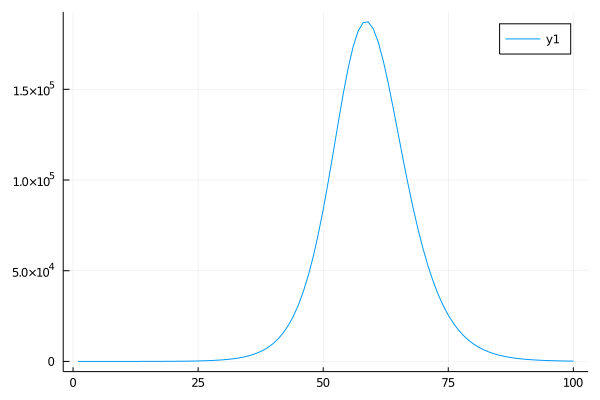

In [17]:
# CONTROL SIMULATION

population1 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params1 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 100)

# Run the model
reset_params!(epi_params1, population1)
set_initial_infected!(epi_params1, population1, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params1, population1; verbose = false)

compartments1 = compartments_as_matrix(epi_params1, population1)
print(size(compartments1))
plot(sum(compartments1, dims=(1,2))[1,1,:,4])

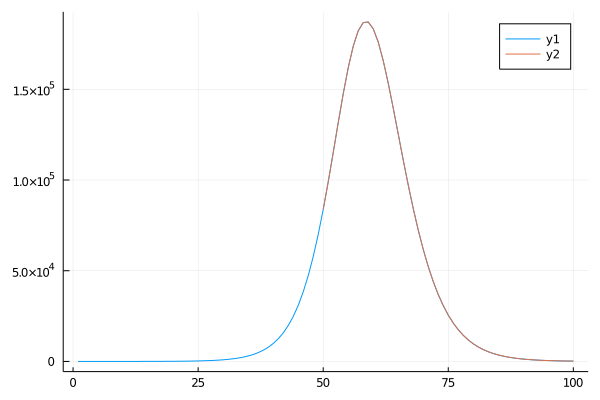

In [18]:
# another simulation with exact same parameters
population2 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params2 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 51)

reset_params!(epi_params2, population2)
set_compartments!(epi_params2, compartments1[:,:,50,:])
run_epidemic_spreading_mmca!(epi_params2, population2; verbose = false)

compartments2 = compartments_as_matrix(epi_params2, population2)

# compare both simulations
y1 = sum(compartments1, dims=(1,2))[1,1,:,4]
y2 = sum(compartments2, dims=(1,2))[1,1,:,4]
plot(1:100, y1)
plot!(50:100, y2)

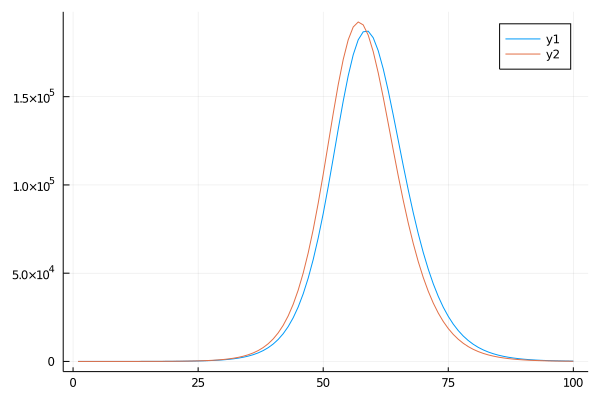

In [19]:
# another simulation that start with a bit different parameters, run until 50 timestamp
population3 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params3 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 100)

beta, scale_beta = 0.077, 0.51 # default values are: 0.075 and 0.5
epi_params3.βᴵ .= beta
epi_params3.βᴬ .= scale_beta * beta

# Run the model
reset_params!(epi_params3, population3)
set_initial_infected!(epi_params3, population3, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params3, population3; verbose = false)

compartments3 = compartments_as_matrix(epi_params3, population3)
plot(sum(compartments1, dims=(1,2))[1,1,:,4])
plot!(sum(compartments3, dims=(1,2))[1,1,:,4])

In [20]:
# correct at time t=50 the infected value with the CONTROL's infected
# reemplazar el compartimento de infectados, calcular los nuevos totales y normalizar

compartments3[:,:,t,4] .= compartments1[:,:,t,4]
totals = sum(compartments3[:,:,t,:], dims=3)
new_compartments = (compartments3[:,:,t,:] ./ totals) .* population3.nᵢᵍ
println(sum(new_compartments, dims=3)./population3.nᵢᵍ)

population4 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params4 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 51)

reset_params!(epi_params4, population4)
set_compartments!(epi_params4, new_compartments)
run_epidemic_spreading_mmca!(epi_params4, population4; verbose = false)

compartments4 = compartments_as_matrix(epi_params4, population4)

# compare both simulations
plot(1:100, sum(compartments1, dims=(1,2))[1,1,:,4], label="Control Simulation")
plot!(1:100, sum(compartments3, dims=(1,2))[1,1,1:100,4], label="2nd simulation βᴵ βᴬ")
plot!(50:100, sum(compartments4, dims=(1,2))[1,1,:,4], label="2nd corrected at t=50")

UndefVarError: UndefVarError: t not defined

In [21]:

plot(1:100, sum(compartments1, dims=(1,2))[1,1,:,3], label="Control Simulation")
plot!(1:100, sum(compartments3, dims=(1,2))[1,1,1:100,3], label="2nd simulation βᴵ βᴬ")
plot!(50:100, sum(compartments4, dims=(1,2))[1,1,:,3], label="2nd corrected at t=50")

UndefVarError: UndefVarError: compartments4 not defined

In [22]:
# TODO:

- crear workflow demo de entrenamiento periodo a periodo
    - con la optimizacion en cada periodo configurable
    - con la imputacion de los compartimentos configurable
- crear grid de plots con compartimentos
- programar lo de la normal multivariada

Imputacion de los compartimentos:
- calcular ratios en lugar de valores completos
- scatterplot de los ratios frente a infectados
- obligar a que los ratios se mantengan
- creo que obligar a que los ratios se mantengan, a la vez que sumen 1, a la vez que los infectados sean X es incompatible



LoadError: syntax: extra token "workflow" after end of expression

# Workflow demo

(3, 5, 300, 10)

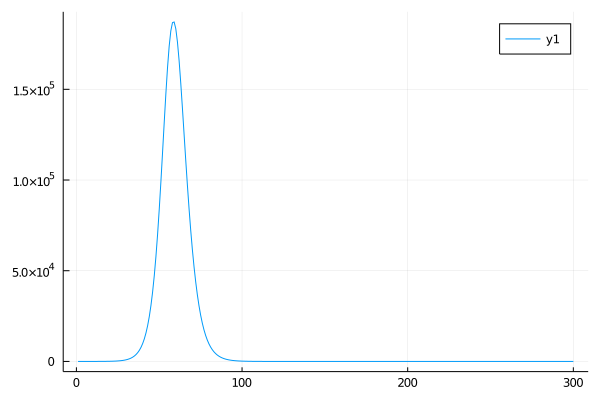

In [27]:
# CONTROL SIMULATION

population1 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params1 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 300)

# Run the model
reset_params!(epi_params1, population1)
set_initial_infected!(epi_params1, population1, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params1, population1; verbose = false)

compartments1 = compartments_as_matrix(epi_params1, population1)
print(size(compartments1))
plot(sum(compartments1, dims=(1,2))[1,1,:,4])

In [29]:
using NamedArrays
simulations_lenght = 100
num_windows = 20
window_size = 10
T = 100

compartments_names = ["S", "E", "A", "I", "PH", "PD", "HR", "HD", "D", "R"]

compartments = NamedArray(
    zeros(G, M, T, num_compartments, num_windows),
    (1:G, 1:M, 1:T, compartments_names, 1:window_size:num_windows*window_size),
    ("G", "M", "t", "compartment", "window")
)

initial_compartments = compartments1[:,:,1,:]

t = 1

for i in 1:num_windows

    println(t, " ", sum(compartments1[:,:,t,4]), " ", sum(initial_compartments[:,:,4]))
    
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, simulations_lenght)

    reset_params!(epi_params, population)
    set_compartments!(epi_params, initial_compartments)
    run_epidemic_spreading_mmca!(epi_params, population; verbose = false)

    compartments[:,:,:,:,i] = compartments_as_matrix(epi_params, population)

    t += window_size
       
    initial_compartments = copy(compartments[:,:,window_size,:,i]) # get compartments of this simulation at the end of the window
    totals = sum(initial_compartments[:,:,:], dims=3)
    initial_compartments[:,:,"I"] = compartments1[:,:,t,4]
    initial_compartments = (initial_compartments ./ totals) .* population.nᵢᵍ
    
end



1 1.0 1.0
11 9.5969256649471 9.5969256649471
21 102.61818312646206 102.61818312646209
31 1145.5155815377002 1145.5155815377002
41 12449.515765041775 12449.515765041771
51 98923.814571105 98923.814571105
61 176051.11323923315 176051.11323923318
71 52269.56794632519 52269.56794632519
81 7961.9298977221615 7961.929897722162
91 1057.5992042791456 1057.5992042791456
101 140.8595480988571 140.8595480988571
111 19.451277742323022 19.45127774232302
121 2.8059771637033237 2.8059771637033233
131 0.4218427309260837 0.42184273092608365
141 0.0656198744634967 0.0656198744634967
151 0.010472939661717962 0.010472939661717962
161 0.001701946867819821 0.001701946867819821
171 0.0002799576034501444 0.00027995760345014446
181 4.641609142343168e-5 4.641609142343168e-5
191 7.734499807415284e-6 7.734499807415284e-6


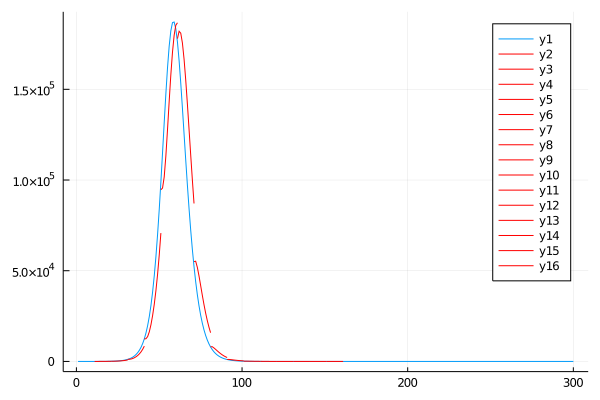

In [30]:

which = 4
points=window_size+1

function plot_simulation!(compartments, w, l)
    x = 1+(window_size*(w-1)):window_size*(w-1)+simulations_lenght
    x = x[1:l]
    y = sum(compartments[:,:,:,which,w], dims=(1,2))[1,1,:]
    y = y[1:l]
    plot!(x, y, color="red", layout=(2,2))
end

plot(sum(compartments1, dims=(1,2))[1,1,:,which])
plot_simulation!(compartments, 2, points)
plot_simulation!(compartments, 3, points)
plot_simulation!(compartments, 4, points)
plot_simulation!(compartments, 5, points)
plot_simulation!(compartments, 6, points)
plot_simulation!(compartments, 7, points)
plot_simulation!(compartments, 8, points)
plot_simulation!(compartments, 9, points)
plot_simulation!(compartments, 10, points)
plot_simulation!(compartments, 11, points)
plot_simulation!(compartments, 12, points)
plot_simulation!(compartments, 13, points)
plot_simulation!(compartments, 14, points)
plot_simulation!(compartments, 15, points)
plot_simulation!(compartments, 16, points)

In [26]:
size(compartments1)

(3, 5, 300, 10)